**Téléchargement et installation de clip**

In [ ]:
! pip install -q ftfy regex tqdm
! pip install -q git+https://github.com/openai/CLIP.git
import clip
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Zero shot prediction et calcul des accuracy top 1 et top 5 sur 50 000 images et 100 labels de Cifar100 (totalité du sous-ensemble d'entrainement)**

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from tqdm import tqdm
import os
import torch


def zero_shot(model_name,batch_size):
  model, preprocess = clip.load(model_name)
  model.cuda().eval()
  cifar100 = CIFAR100(os.path.expanduser("~/.cache"),transform=preprocess, download=True)

  cifar100_loader = DataLoader(cifar100, batch_size=batch_size, shuffle=False)

  total = 0
  correct_top1 = 0
  correct_top5 = 0

  text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
  text_tokens = clip.tokenize(text_descriptions).cuda()

  with torch.no_grad():
      text_features = model.encode_text(text_tokens).float()
      text_features /= text_features.norm(dim=-1, keepdim=True)

  #batch processing
  for batch_images, batch_labels in tqdm(cifar100_loader):
      images = []
      labels = []
      for image in batch_images:
          images.append(image)
      image_input = torch.tensor(np.stack(images)).cuda()
      with torch.no_grad():
          image_features = model.encode_image(image_input).float()
      image_features /= image_features.norm(dim=-1, keepdim=True)
      labels.extend(batch_labels.tolist()) #nous pouvons utiliser extend puisqu'on reset la liste labels au début de la boucle
      total += len(labels)
      text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
      top_probs1, top_labels1 = text_probs.cpu().topk(1, dim=-1)
      top_probs5, top_labels5 = text_probs.cpu().topk(5, dim=-1)
      for i,prediction in enumerate(top_labels1) :
        if prediction == labels[i]:
          correct_top1+=1
        if labels[i] in top_labels5[i] :
          correct_top5+=1


  print("\nScore top 1 : ", correct_top1," / ",total)
  print("\nScore top 5 : ", correct_top5," / ",total)
  accuracy_top1 = correct_top1/total
  accuracy_top5 = correct_top5/total
  print("\nAccuracy top 1 : ", accuracy_top1)
  print("\nAccuracy top 5 : ", accuracy_top5)
  return [accuracy_top1,accuracy_top5]

**Calcul des scores pour tous les modèles de CLIP disponibles**

In [ ]:
performances = []
batch_sizes = [1000,1000,500,200,200,1000,1000,400,500]
for i,clip_model in enumerate(clip.available_models()):
  print("Starting the evaluation of the following CLIP model :",clip_model)
  if(i==4):
    print("This model is too heavy, it will be trained separately - SKIPPED")
    continue
  performances.append(zero_shot(clip_model,batch_sizes[i]))



Starting the evaluation of the following CLIP model : RN50


100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 73.9MiB/s]


100%|██████████| 169001437/169001437 [00:19<00:00, 8837513.20it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


100%|██████████| 50/50 [03:27<00:00,  4.16s/it]



Score top 1 :  19875  /  50000

Score top 5 :  35726  /  50000

Accuracy top 1 :  0.3975

Accuracy top 5 :  0.71452
Starting the evaluation of the following CLIP model : RN101


100%|███████████████████████████████████████| 278M/278M [00:06<00:00, 48.2MiB/s]


Files already downloaded and verified


100%|██████████| 50/50 [04:02<00:00,  4.85s/it]



Score top 1 :  22930  /  50000

Score top 5 :  37470  /  50000

Accuracy top 1 :  0.4586

Accuracy top 5 :  0.7494
Starting the evaluation of the following CLIP model : RN50x4


100%|███████████████████████████████████████| 402M/402M [00:10<00:00, 41.5MiB/s]


Files already downloaded and verified


100%|██████████| 100/100 [07:25<00:00,  4.45s/it]



Score top 1 :  18350  /  50000

Score top 5 :  32540  /  50000

Accuracy top 1 :  0.367

Accuracy top 5 :  0.6508
Starting the evaluation of the following CLIP model : RN50x16


100%|███████████████████████████████████████| 630M/630M [00:12<00:00, 51.1MiB/s]


Files already downloaded and verified


100%|██████████| 250/250 [16:26<00:00,  3.95s/it]



Score top 1 :  23723  /  50000

Score top 5 :  36969  /  50000

Accuracy top 1 :  0.47446

Accuracy top 5 :  0.73938
Starting the evaluation of the following CLIP model : RN50x64
This model is too heavy, it will be trained separately - SKIPPED
Starting the evaluation of the following CLIP model : ViT-B/32


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 69.3MiB/s]


Files already downloaded and verified


100%|██████████| 50/50 [02:55<00:00,  3.51s/it]



Score top 1 :  29426  /  50000

Score top 5 :  42622  /  50000

Accuracy top 1 :  0.58852

Accuracy top 5 :  0.85244
Starting the evaluation of the following CLIP model : ViT-B/16


100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 47.1MiB/s]


Files already downloaded and verified


100%|██████████| 50/50 [04:40<00:00,  5.62s/it]



Score top 1 :  32471  /  50000

Score top 5 :  43964  /  50000

Accuracy top 1 :  0.64942

Accuracy top 5 :  0.87928
Starting the evaluation of the following CLIP model : ViT-L/14


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 77.9MiB/s]


Files already downloaded and verified


100%|██████████| 125/125 [12:05<00:00,  5.80s/it]



Score top 1 :  35217  /  50000

Score top 5 :  45366  /  50000

Accuracy top 1 :  0.70434

Accuracy top 5 :  0.90732
Starting the evaluation of the following CLIP model : ViT-L/14@336px


100%|███████████████████████████████████████| 891M/891M [00:11<00:00, 80.7MiB/s]


Files already downloaded and verified


 89%|████████▉ | 89/100 [25:26<03:08, 17.15s/it]


OutOfMemoryError: ignored

**Calcul des scores séparé (Redémarrage du GPU)**

In [ ]:
 performances.append(zero_shot('RN50x64',150))

Files already downloaded and verified


100%|██████████| 334/334 [43:02<00:00,  7.73s/it]


Score top 1 :  24380  /  50000

Score top 5 :  36992  /  50000

Accuracy top 1 :  0.4876

Accuracy top 5 :  0.73984


**Calcul des scores séparé (Redémarrage du GPU)**

In [ ]:
 performances.append(zero_shot('ViT-L/14@336px',400))

100%|███████████████████████████████████████| 891M/891M [00:11<00:00, 79.6MiB/s]


100%|██████████| 169001437/169001437 [00:05<00:00, 30708495.50it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


100%|██████████| 125/125 [30:10<00:00, 14.49s/it]


Score top 1 :  34853  /  50000

Score top 5 :  45297  /  50000

Accuracy top 1 :  0.69706

Accuracy top 5 :  0.90594


**Reformattage de la liste des performances (Redémarrage du notebook)**

**Comparaison des performances des modèles**

In [ ]:
performances = []
performances = [[0.3975, 0.71452], [0.4586, 0.7494], [0.367, 0.6508], [0.47446, 0.73938], [0.4876, 0.73984], [0.58852, 0.85244], [0.64942, 0.87928], [0.70434, 0.90732], [0.69706, 0.90594]]

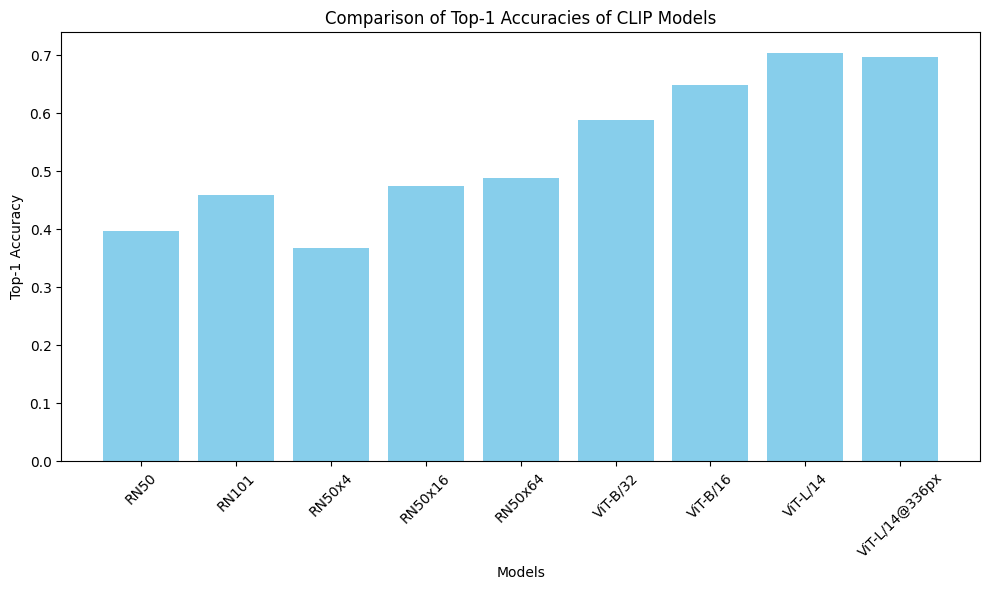

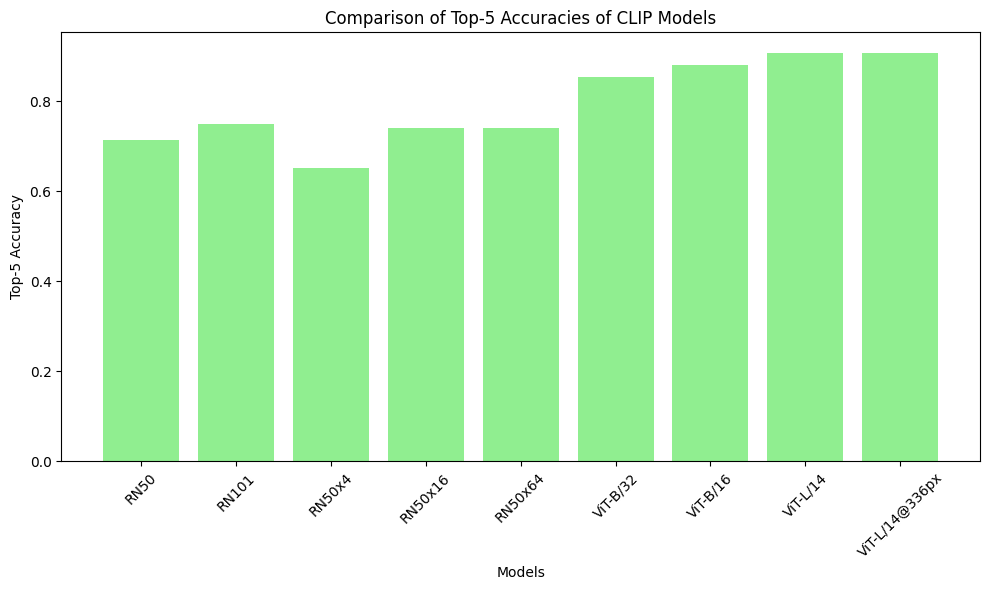

In [ ]:
import matplotlib.pyplot as plt

model_names = clip.available_models()

top1_accuracies = [performance[0] for performance in performances]
top5_accuracies = [performance[1] for performance in performances]

plt.figure(figsize=(10, 6))
plt.bar(model_names, top1_accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Top-1 Accuracy')
plt.title('Comparison of Top-1 Accuracies of CLIP Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(model_names, top5_accuracies, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Top-5 Accuracy')
plt.title('Comparison of Top-5 Accuracies of CLIP Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
